# part 1 : the snowplow problem

A snowplow must clean the snow in front of 1000 houses. The position of each house is represented by a float number (not necessary positive). Initially, the snow- plow is in 0. The traveling time of the snowplow is equivalent to the distance that it went through since the beginning of the day. If there are several houses at the same point, it does not take a longer time to clean the snow (the snow is cleaned as soon as the snowplow has passed). However, since the positions of the houses are represented as floats, this should not happen often.

The snowplow must minimize the average waiting time before the snow is clea- ned in front of the houses, from the point of view of the houses.

Conventions : You must write a function that takes has input the positions of the 1000 houses, and outputs the positions of the houses, sorted in the same order as they are cleaned.

In [1]:
# for inline plots in jupyter
%matplotlib inline
# import matplotlib
import matplotlib.pyplot as plt
# for latex equations
from IPython.display import Math, Latex
# for displaying images
from IPython.core.display import Image

import pandas as pd
import numpy as np

In [2]:
!pip3 install seaborn

In [3]:
# import seaborn
import seaborn as sns
# settings for seaborn plotting style
sns.set(color_codes=True)
# settings for seaborn plot sizes
sns.set(rc={'figure.figsize':(5,5)})

## Part 1: Generating different test set
I'm going to put some random test set into a pandas DataFrame to test my function on different use cases

In [4]:
houseDf = pd.DataFrame()

### Different random distribution for different test sets

The goal in this part is to generate diffenrent sets of houses for testing purposes

    1.Uniform Distribution
Since any interval of numbers of equal width has an equal probability of being observed, the curve describing the distribution is a rectangle, with constant height across the interval and 0 height elsewhere. Since the area under the curve must be equal to 1, the length of the interval determines the height of the curve. The following figure shows a uniform distribution in interval (a,b). Notice since the area needs to be 1
. The height is set to 1/(b−a)
.

In [5]:
# import uniform distribution
from scipy.stats import uniform

In [6]:
# random numbers from uniform distribution
n = 1000
start = -100
end = 100
width = end - start
data_uniform = uniform.rvs(size=n, loc = start, scale=width)
houseDf['uniform'] = data_uniform

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Uniform Distribution ')]

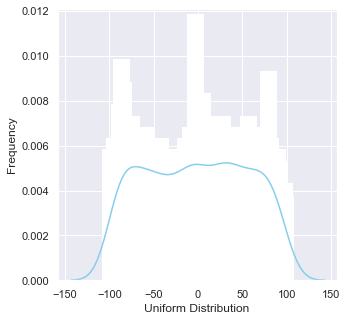

In [7]:
ax = sns.distplot(data_uniform,
                  bins=100,
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='Uniform Distribution ', ylabel='Frequency')

    2.Normal distribution

A normal distribution has a bell-shaped density curve described by its mean μ
 and standard deviation σ
. The density curve is symmetrical, centered about its mean, with its spread determined by its standard deviation showing that data near the mean are more frequent in occurrence than data far from the mean.


In [8]:
from scipy.stats import norm
# generate random numbers from N(0,1)
data_normal = np.random.normal(0,1000,1000).tolist()
houseDf['normal'] = data_normal
#let's try this on a normal distribution
houseArray = np.random.normal(0,1000,1000).tolist()

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Normal Distribution')]

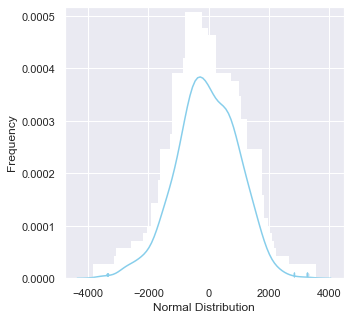

In [9]:
ax = sns.distplot(data_normal,
                  bins=100,
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='Normal Distribution', ylabel='Frequency')

    3 Gamma distribution
The gamma distribution is a two-parameter family of continuous probability distributions. While it is used rarely in its raw form but other popularly used distributions like exponential, chi-squared, erlang distributions are special cases of the gamma distribution. The gamma distribution can be parameterized in terms of a shape parameter α=k
 and an inverse scale parameter β=1/θ
, called a rate parameter., the symbol Γ(n)
 is the gamma function and is defined as (n−1)!


In [10]:
from scipy.stats import gamma
data_gamma = gamma.rvs(a=5, size=n)
houseDf['gamma'] = data_gamma

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Gamma Distribution')]

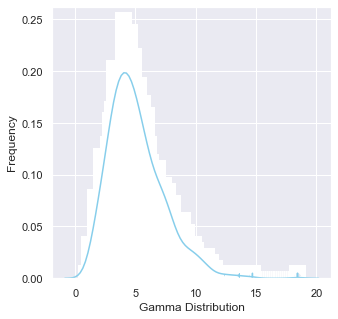

In [11]:
ax = sns.distplot(data_gamma,
                  kde=True,
                  bins=100,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='Gamma Distribution', ylabel='Frequency')


    4. Homemade sinuzoid distribution
The goal here is to create multiple sinuozoids to test some sinuzoid houses distribution

In [12]:
def generate_sinewave(length = 1000, frequency = 2, amplitude = 100):
    x = np.linspace(0, frequency * np.pi, length)
    sinewave = np.sin(x) * amplitude
    return sinewave

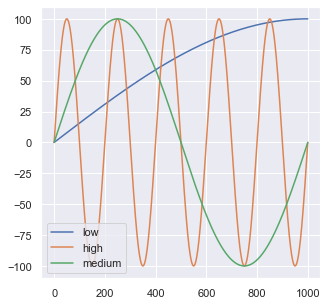

In [13]:
houseDf['sinewave_lowf'] = generate_sinewave(frequency = 0.5)
houseDf['sinewave_highf'] = generate_sinewave(frequency = 10)
houseDf['sinewave_mediumf'] = generate_sinewave(frequency = 2)
plt.plot(houseDf['sinewave_lowf'], label='low')
plt.plot(houseDf['sinewave_highf'], label='high')
plt.plot(houseDf['sinewave_mediumf'], label='medium')
plt.legend()

## Part 2: algorithm

### Time evaluation function
First thing first: we must create the function that will evaluate the performance of the algorithms by actually do the snow cleaning :)

In [14]:
import math

def evaluate(houseArray):
    lastPosition = 0
    distance = 0
    for house in houseArray:
        distance += abs(house - lastPosition)
        lastPosition = house
    return distance

def evaluateWaitingAverage(houseArray):
    waitingTimes = []
    lastPosition = 0
    distance = 0
    for house in houseArray:
        distance += abs(house - lastPosition)
        lastPosition = house
        waitingTimes.append(distance)
    return np.average(waitingTimes)
    

Now let's test the evaluation function on two cases

In [15]:
# as the cleaner begins at position 0, this should return 4
testCaseA = [1, 2, 3, 4]
print(f"Simple distance evaluation should output 4, output: {evaluate(testCaseA)}")
print(f"Mean waiting time evaluation should output 2.5, output: {evaluateWaitingAverage(testCaseA)}")

Simple distance evaluation should output 4, output: 4
Mean waiting time evaluation should output 2.5, output: 2.5


In [16]:
print(abs(0 - 150) + abs(-150 - 3) + abs(125 - 3))
testCaseB = [-150, 3, 125]
print(f"Simple distance evaluation should output 425, output: {evaluate(testCaseB)}")
print(f"Mean waiting time evaluation should output 2.5, output: {evaluateWaitingAverage(testCaseB)}")

# the two prints must be the same

425
Simple distance evaluation should output 425, output: 425
Mean waiting time evaluation should output 2.5, output: 292.6666666666667


### Greedy algorithm
Let's write the greedy algorithm that looks like what must have been written by M.lehir

In [17]:
# from: https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# way faster thanks to the use of searchsorted
def find_nearest_sorted(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

In [18]:
# this only goes to the closest house without looking further 
def greedy_baseline(houseArray):
    # let's sort the array for optimization matter
    houseArray = np.sort(houseArray)
    currentPos = 0
    result = []
    while len(houseArray) > 0:
        nearestIdx = find_nearest_sorted(houseArray, currentPos)
        nearest = houseArray[nearestIdx]
        result.append(nearest)
        currentPos = nearest
        houseArray = np.delete(houseArray, nearestIdx)
        
    return result

In [19]:
#let's try this on a normal distribution
houseArray = np.random.normal(0,1000,1000).tolist()

resultArray = greedy_baseline(np.array(houseArray))
resultDistance = evaluate(resultArray)
resultTimesFromHousePoV = evaluateWaitingAverage(houseArray)
print(resultDistance)
print(resultTimesFromHousePoV)

9571.54863972752
567341.8918348068


#### Let's try this baseline on every distribution

In [20]:
# creating a dataframe to hold the results
resultDf = pd.DataFrame(({"distributions": houseDf.columns}))
resultDf.set_index("distributions")
resultDf

,distributions
0,uniform
1,normal
2,gamma
3,sinewave_lowf
4,sinewave_highf
5,sinewave_mediumf


In [21]:
resultDf['base_distance'] = [evaluate(greedy_baseline(np.array(houseDf[column]))) for column in houseDf]
resultDf['base_waitingMean'] = [evaluateWaitingAverage(greedy_baseline(np.array(houseDf[column]))) for column in houseDf]


resultDf

,distributions,base_distance,base_waitingMean
0,uniform,299.211095,150.903259
1,normal,10181.840422,4286.708774
2,gamma,18.470941,5.062607
3,sinewave_lowf,100.000000,63.648302
4,sinewave_highf,299.999629,163.398139
5,sinewave_mediumf,299.999629,163.398139


### The naive solution without optimization
Let's try to code the solution without worrying about the optimization, it's gonna lead to an exponential solution but it is going to be the base of the reflexion


In [22]:
incr = 0

In [23]:
# we need a very short list as it's gonna be NP
simpleHouseList = [-5, 2, 3, 14, 15, -100, 17, 18]

def naive_findShortestPathMinizingWait(houseList, currentDistance = 0, currentPos = 0, currentAvg = 0, depth = 1):
    if len(houseList) == 0:
        return (currentDistance, currentAvg, [currentPos])
    global incr

    incr = incr + 1
    bestDistance = None
    bestPath = [currentPos]
    
    for house in houseList:    
        # variable preparations
        newHouseList = [h for h in houseList if h is not house]
        tmpPos = house
        tmpDistance = currentDistance + abs(tmpPos - currentPos)
        tmpAvg = currentAvg + (tmpDistance - currentAvg) / depth
        
        # recursion
        (newDistance, newAvg, newPath) = naive_findShortestPathMinizingWait(newHouseList, tmpDistance, house, tmpAvg, depth + 1)
        
        if bestDistance == None or newDistance < bestDistance:
            bestDistance = newDistance
            bestAvg = newAvg
            bestPath = [currentPos] + newPath
    return (bestDistance, bestAvg, bestPath)
    

In [24]:
(bestDistance, bestAvg, bestPath) = naive_findShortestPathMinizingWait(simpleHouseList)

print(f"bestDistance: {bestDistance} bestAvg: {bestAvg} bestPath: {bestPath}")
print(f"distance evaluation: {evaluate(bestPath)} mean waiting evaluation: {evaluateWaitingAverage(bestPath)}")
print(f"incr happened: {incr} times")




bestDistance: 136 bestAvg: 30.75 bestPath: [0, 2, 3, 14, 15, 17, 18, -5, -100]
distance evaluation: 136 mean waiting evaluation: 27.333333333333332
incr happened: 69281 times


In [25]:
(0 + 1 + 2 + 3 + 4 + 5) / 6

2.5

In [26]:
# this is just a test to how to compute the avg "online"
mean = 0
for number in range(6):
    mean = mean + (number - mean) / (number + 1)
print(mean)

2.5


#### Conclusion time: What can we deduce of this experiment ?
This is clearly impossible with a big n. the simpleHouseList takes around 68k tests for only 8 elements.
So let's find a way to reduce the number of operations while keeping an acceptable heuristic

## Heuristics

I'm gonna first create a function to evaluate multiple heuristics as functions

In [27]:
# this only goes to the closest house without looking further 
def greedy_withHeuristic(houseArray, heuristicFunc):
    # let's sort the array for optimization matter
    # numpy uses a mergesort https://docs.scipy.org/doc/numpy/reference/generated/numpy.sort.html
    # which is O(n * log(n))
    houseArray = np.sort(houseArray)
    
    # the snow machine does not begin at index 0 but at value 0.
    # We must find the index of the value 0
    currentPos = 0    

    result = []
    while len(houseArray) > 0:

        # calculating the heuristic for this iteration
        heuristicArray = heuristicFunc(houseArray, currentPos)
        
        # looking for the minimal value of the heuristic function result: O(n)
        minHeuristicValue = np.amin(heuristicArray)
        minIdx = np.where(heuristicArray == minHeuristicValue)[0][0]
        minValue = houseArray[minIdx]
        
        # now we need to reach the minValue position
        # by passing by all the values between currentPos and minValue
        drivingIdx = find_nearest_sorted(houseArray, currentPos)
        if minValue > currentPos:
            if houseArray[drivingIdx] < currentPos:
                drivingIdx += 1
        elif minValue < currentPos:
            if houseArray[drivingIdx] > currentPos:
                drivingIdx -= 1
            
        
        # check if we are going left or right
        negRet = (1, -1)[drivingIdx > minIdx]
        
        # going left or right, and adding the houses to the result set
        rangeToGo = range(drivingIdx, minIdx + negRet, negRet)
        # print(rangeToGo)
        for i in rangeToGo:
            result.append(houseArray[i])
            
        # creating a mask to delete all the houses we have came through
        houseToDeleteMask = np.full((len(houseArray)), True)

        houseToDeleteMask[rangeToGo] = False
        
        # deleting the houses we have been on
        houseArray = houseArray[houseToDeleteMask]
        
        # setting currentPos for the next loop iteration
        currentPos = minValue
        
    return result

### the Nearest neighbour (NN) heuristic

In [28]:
def greedy_nearestHeuristic(houseArray, currentPosValue):
    heuristicArray = np.array(houseArray)
    for i in range(len(heuristicArray)):
        score = abs(houseArray[i] - currentPosValue)
        heuristicArray[i] = score
    return heuristicArray

greedy_withHeuristic(np.array(simpleHouseList), greedy_nearestHeuristic)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


[2, 3, -5, 14, 15, 17, 18, -100]

### the povDistance heuristic
This heuristic calculates for every children the sum of all the distances between it and the others + the distance between it and current position

In [45]:
def _povDistance_iteration(houseArray, currentPosValue):

    for i in np.nditer(houseArray):    
        score = abs(i - currentPosValue) * len(houseArray)
        #score += np.sum([abs(j - i) for j in houseArray])
        score += np.sum(nb.abs(houseArray - i))
        #for j in np.nditer(houseArray):
        #    score += abs(j - i)
        yield score
    
    for i in np.nditer(houseArray):    
        score = abs(i - currentPosValue) * len(houseArray)
        for j in np.nditer(houseArray):
            score += abs(j - i)
        yield score
    

def greedy_povDistanceHeuristic(houseArray, currentPosValue):
    # heuristicArray = np.zeros(len(houseArray))
    
    # heuristicArray = [abs(i - currentPosValue) +  np.sum(np.abs(houseArray - i) + np.abs(houseArray - currentPosValue)) for i in houseArray]
    heuristicArray = [abs(i - currentPosValue) +  np.sum(np.abs(houseArray - i)) for i in houseArray]
    #print(f"curPosValue: {currentPosValue} normal:    {houseArray}\nheuristic: {heuristicArray}")
    heuristicArray = heuristicArray + np.abs(houseArray - currentPosValue)
 
    
    
    #heuristicArray = abs(houseArray - currentPosValue) + np.sum(np.abs(np.ones([len(houseArray),len(houseArray)]) * houseArray - houseArray.reshape((len(houseArray),1))),axis=1)
    #print(f"curPosValue: {currentPosValue} normal:    {houseArray}\nheuristic: {heuristicArray}")
    # heuristicArray = list(_povDistance_iteration(houseArray, currentPosValue))
    return heuristicArray
    
simpleHouseList = [-5, 2, 3, 14, 15, -100, 17, 18, 22]
greedy_withHeuristic(np.array(simpleHouseList), greedy_povDistanceHeuristic)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


[2, 3, 14, 15, 17, 18, 22, -5, -100]

In [47]:
evaluateWaitingAverage(greedy_withHeuristic(np.array(houseDf["sinewave_highf"]), greedy_povDistanceHeuristic))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


[0.0,
 -1.2246467991473532e-13,
 -0.31447322077359985,
 0.3144732207739443,
 0.6289433316067027,
 0.9434072225900002,
 -0.628943331606914,
 -0.9434072225895225,
 -1.2578617838742612,
 -1.5723039057039634,
 1.2578617838739612,
 1.5723039057042631,
 1.886730478446403,
 2.2011383926229358,
 -1.8867304784468808,
 -2.201138392622636,
 -2.5155245389376844,
 -2.8298858083113503,
 2.5155245389372953,
 2.8298858083118277,
 3.1442190919120603,
 3.4585212811818886,
 -3.1442190919123867,
 -3.4585212811816772,
 -3.7727892678720605,
 -4.087019944071032,
 3.772789267871673,
 4.087019944071332,
 4.401210202238048,
 4.715356935230757,
 -4.401210202238525,
 -4.715356935230457,
 -5.029457036336817,
 -5.343507399305471,
 5.029457036336518,
 5.343507399305771,
 5.6575049183787955,
 5.971446488321034,
 -5.657504918379272,
 -5.971446488320734,
 -6.28532900444837,
 -6.599149362662023,
 6.285329004448194,
 6.59914936266241,
 6.912904459478346,
 7.226591192059077,
 -6.912904459478647,
 -7.226591192058601,
 -7.5

In [43]:
resultDf['povAdd_waitingMean'] = [evaluateWaitingAverage(greedy_withHeuristic(np.array(houseDf[column]), greedy_povDistanceHeuristic)) for column in houseDf]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


In [44]:
resultDf

,distributions,base_distance,base_waitingMean,povAdd_waitingMean
0,uniform,299.211095,150.903259,8293.832759
1,normal,10181.840422,4286.708774,119430.459350
2,gamma,18.470941,5.062607,5.062607
3,sinewave_lowf,100.000000,63.648302,63.648302
4,sinewave_highf,299.999629,163.398139,11639.137490
5,sinewave_mediumf,299.999629,163.398139,11639.137490


### Analysis of this heuristic
The results are terrible. The reason is that the snowPlow is attracted by the higher density part of houses. but each time that it cleans a house, as the house is removed from the array, the density of the current density cluster is lowered, so it goes back on it's trail to another cluster instead of finishing the current one.

Maybe this heuristic did not work because it was recalculated at each iteration

First thought: it might be possible to develop an A* like algorithm that performs a research only on a subgraph.

In [33]:
import collections
from queue import PriorityQueue

In [34]:
HouseNode = collections.namedtuple('houseNode', ['idx', 'value', 'cost'])

In [69]:
def _recreate_astar_path(houseArray, cameFrom, currentIdx):
    path = []
    while cameFrom[currentIdx] != None:
        path.append(houseArray[currentIdx])
        currentIdx = cameFrom[currentIdx]
    path.append(currentIdx)
    return path

# algo inspired by: https://en.wikipedia.org/wiki/A*_search_algorithm
def _astar(houseArray, heuristicFunc):
    houseArray = np.append(houseArray, 0)
    houseArray = np.sort(houseArray)
    currentIdx = np.searchsorted(houseArray, 0)
    # The set of discovered nodes that may need to be (re-)expanded.
    # Initially, only the start node is known.
    # This is usually implemented as a min-heap or priority queue rather than a hash-set.
    openSet = PriorityQueue()
    openSet.put((0, currentIdx))
    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start
    # to n currently known.    
    cameFrom = dict()
    cameFrom[currentIdx] = None
    
    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    gscore = np.full(len(houseArray), np.inf)
    gscore[currentIdx] = 0
    print(f"gscore: {gscore}")
    
    # For node n, fScore[n] := gScore[n] + h(n). fScore[n] represents our current best guess as to
    #  how short a path from start to finish can be if it goes through n.
    fscore = np.full(len(houseArray), np.inf)
    fscore[currentIdx] = 0
    print(f"gscore: {fscore}")
    
    while (openSet.qsize() > 0):
        currentIdx = openSet.get()[1]
        neighboursIdx = []
        if currentIdx - 1 >= 0:
            neighboursIdx.append(currentIdx - 1)
        if currentIdx + 1 < houseArray.shape[0]:
            neighboursIdx.append(currentIdx + 1)
        print(f"current: {currentIdx} neighbours: {neighboursIdx}")
        for neighbourIdx in neighboursIdx:
            # current distance + new distance
            tentative_gscore = gscore[currentIdx] + abs(houseArray[neighbourIdx] - houseArray[currentIdx])
            
            if tentative_gscore < gscore[neighbourIdx]:
                cameFrom[neighbourIdx] = currentIdx
                gscore[neighbourIdx] = tentative_gscore
                fscore[neighbourIdx] = tentative_gscore + heuristicFunc(_recreate_astar_path(houseArray, cameFrom, neighbourIdx))
                if neighbourIdx not in [el[1] for el in openSet.queue]:
                    openSet.put((fscore[neighbourIdx], neighbourIdx))
    print(cameFrom)
    
_astar([2, 17, 18, 22, -5, -100], evaluateWaitingAverage)

gscore: [inf inf  0. inf inf inf inf]
gscore: [inf inf  0. inf inf inf inf]
current: 2 neighbours: [1, 3]
current: 3 neighbours: [2, 4]
current: 1 neighbours: [0, 2]
current: 4 neighbours: [3, 5]
current: 5 neighbours: [4, 6]
current: 6 neighbours: [5]
current: 0 neighbours: [1]
{2: None, 1: 2, 3: 2, 4: 3, 0: 1, 5: 4, 6: 5}


In [ ]:
astarlike_findShortestPathMinizingWait(simpleHouseList)

In [ ]:
np.searchsorted([1,2,4,5], 3, side='right')

In [ ]:
arr = np.array([-5, -4, -3, -2, 0, 1, 2, 3, 4, 5, 6])

arr - 
np.abs(arr)

In [61]:
from queue import PriorityQueue
customers = PriorityQueue() #we initialise the PQ class instead of using a function to operate upon a list. 
customers.put((2, "Harry"))
customers.put((3, "Charles"))
customers.put((1, "Riya"))
customers.put((4, "Stacy"))
while customers:
     print(customers.get())
#Will print names in the order: Riya, Harry, Charles, Stacy.

(1, 'Riya')
(2, 'Harry')
(3, 'Charles')
(4, 'Stacy')


KeyboardInterrupt: 